In [1]:
from qiskit import execute, Aer
from qiskit import QuantumCircuit, QuantumRegister

from qiskit.providers import JobStatus
from qiskit.tools.qi.qi import partial_trace
from qiskit.quantum_info import state_fidelity
from qiskit.compiler import transpile
from qiskit.quantum_info.random.utils import random_state

import time

from pairwise_tomography.pairwise_state_tomography_circuits import pairwise_state_tomography_circuits
from pairwise_tomography.pairwise_fitter import PairwiseStateTomographyFitter
from pairwise_tomography.utils import concurrence

backend = Aer.get_backend('qasm_simulator')

We create a QuantumCircuit

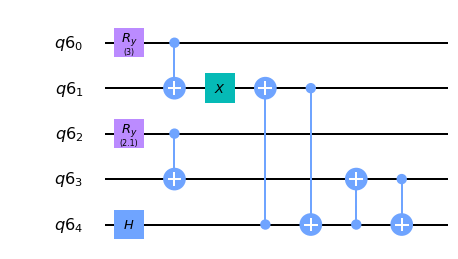

In [74]:
nq = 5

q = QuantumRegister(nq)
qc = QuantumCircuit(q)

qc.ry(3., q[0])
qc.cx(q[0], q[1])
qc.x(q[1])
qc.ry(2.1, q[2])
qc.cx(q[2], q[3])
qc.h(q[4])
qc.cx(q[4], q[1])
qc.cx(q[1], q[4])
qc.cx(q[4], q[3])
qc.cx(q[3], q[4])

qc.draw(output='mpl')

We now prepare the circuits for the pairwise tomography for all the qubits

In [75]:
pw_tomo_circs = pairwise_state_tomography_circuits(qc, range(nq))

In [76]:
print(len(pw_tomo_circs))

15


Notice that we only need to run 15 measurement circuits

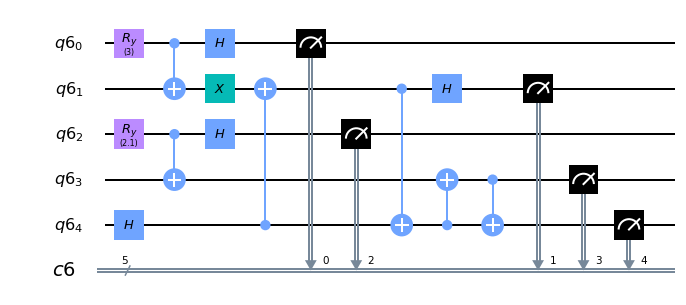

In [77]:
pw_tomo_circs[10].draw(output='mpl')

In [78]:
job = execute(pw_tomo_circs, Aer.get_backend('qasm_simulator'), shots=8192)

In [79]:
fitter = PairwiseStateTomographyFitter(job.result(), pw_tomo_circs, range(nq))

In [80]:
fit_result = fitter.fit()

The result of `fit()` is a dictionary containing the reconstructed two-qubit density matrices for all pairs of qubits required.

```
{(i, j) : rho(i,j)}
```

You can specify the pairs of qubits you are interested in by passing a list of pairs, eg 
```
fit_result = fitter.fit([(0, 1), (1, 2) , (0, 2)])
```

In [82]:
print(fit_result[(0,1)])

[[ 2.70701985e-03+0.j          8.69002274e-05+0.00206469j
   2.74629615e-03-0.00030326j -1.39292028e-03+0.0033222j ]
 [ 8.69002274e-05-0.00206469j  4.96227925e-01+0.j
   2.28502318e-03+0.00155317j  4.96489636e-01+0.0066464j ]
 [ 2.74629615e-03+0.00030326j  2.28502318e-03-0.00155317j
   2.85908033e-03+0.j          6.80165674e-04-0.0004115j ]
 [-1.39292028e-03-0.0033222j   4.96489636e-01-0.0066464j
   6.80165674e-04+0.0004115j   4.98205975e-01+0.j        ]]


### Example: pairwise entanglement

Here we show an application: the evaluation of pairwise entanglement, and visualization of the entanglement graph

In [83]:
pairwise_entanglement = {key: concurrence(value) for key, value in fit_result.items()}

In [84]:
print(pairwise_entanglement)

{(0, 1): 0.004602700510645892, (0, 2): 0.0, (0, 3): 0.07976017644878777, (0, 4): 0.0, (1, 2): 0.0037884419069294482, (1, 3): 0.005866839252321538, (1, 4): 0.005356157627417021, (2, 3): 0.005797682931896697, (2, 4): 0.010750282226058394, (3, 4): 0.006866221206912437}


In [85]:
from pairwise_tomography.visualization import draw_entanglement_graph

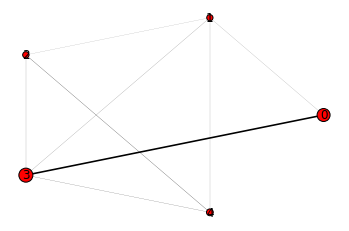

In [86]:
draw_entanglement_graph(pairwise_entanglement, range(nq))